In [1]:
# the purpose of this notebook is to continue testing model stability

## NEW ADDITIONS 
# exponentially decrease sediment transport such that  minimal transport occurs as the width : depth goes below 2
# make single lithology, for simplicity while testing
# downsize to examine 2 cell model
# gradually scale up, if math seems to operate correctly

In [2]:
# IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# DEFINE PARAMETERS

dx = 1000 # grid spacing, m
x = np.arange(0, 2000, dx) # domain length, m
x_node = x + (dx/2) # node-centered x, m

beta = np.zeros(len(x)) # abrasion coeffcient, 1/m
beta[:] = 4e-5
psi = 4e-5 # attrition factor, 1/m

K = np.zeros(len(x)) # rock erodibility, 1/m
K[:] = 1e-9

gamma = np.zeros(len(x)) # fraction of coarse material from hillslopes
gamma[:] = 0.3
r = 10. # runoff rate, m/yr

Hstar = 0.5 # characteristic sediment thickness, m
phi = 0.55 # sediment porosity
D = 0.03 # grain size, m

kxb = 25 # valley width coeffcient
Pxb = 1./5. # valley width exponent
kb = 8.3e-8 # channel width coeffcient
kqs = 0.041 # sediment discharge coefficient
I = 0.01 # intermittency factor

baselevel_rate = 0.0005 # baselevel fall rate, m/yr

In [4]:
x_node[1]

1500.0

In [5]:
# SET UP ARRAYS

H = 100 * Hstar + np.zeros(len(x)) # sediment thickness, m

etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope

eta = etab + H # total topographic elevation, m

In [6]:
# CALCULATE CONSTANT, DERIVATIVE VALUES

B_valley = kxb * (x_node**Pxb) # valley width, m
B = (2./3.) * x_node # basin width at any point along channel, m

area = (1./3.) * (x**2) # area set by Hack's law, m^2
Q = r * area # total basin discharge, m^3/yr
q = Q/B_valley # unit discharge, m^2/yr

In [7]:
len(x)

2

In [8]:
def model(dx, x, x_node, # grid setup parameters
          beta, psi, # abrasion properties
          K, # erodibility
          gamma, r, # hillslope properties
          Hstar, phi, D, # sediment properties
          kxb, Pxb, kb, kqs, I, # wickert and schildgen coeffcients
          baselevel_rate, # lowering rate
          H, etab, eta, # topography information
          B_valley, B, area, Q, q, # drainage basin properties
          num_steps = 1): # number of steps
    
    # calculate timestep
    dt_global = 0.2 * (0.2 * dx * dx / (kqs*(Q[-1]/B[-1]))) # default timestep, yrs
    tau = 100 # timescale for hillslope response, yrs
    run_duration = dt_global * num_steps # total amount of time to run, yrs
    cum_time = 0.0 # time elapsed, yrs
    
    # define arrays
    b = np.zeros(len(x)) # channel width, m,
    Eb_p = np.zeros(len(x)) # plucking rate, m/yr,
    Eb_a = np.zeros(len(x)) # abrasion rate, m/yr,
    Eb = np.zeros(len(x)) # bedrock erosion rate, m/yr,
    Eh = np.zeros(len(x)) # sediment erosion rate, m/yr,
    E = np.zeros(len(x)) # total erosion rate, m/yr,
    Qs = np.zeros(len(x)) # total sediment transport, m^3/yr,
    qs = np.zeros(len(x)) # unit sediment transport, m^2/yr,
    ql = np.zeros(len(x)) # lateral sediment supply, m^2/yr,
    E_vals = np.zeros((2, len(x))) # store current and past erosion rates in this array, m/yr,
    E_avg = np.zeros(len(x)) # weighted average erosion rates, m/yr
    
    # set boundary conditions
    b[0] = 0 # channel width,
    H[-1] = 0 # sediment thickness,
    E[-1] = baselevel_rate # lowering rate,
    q[0] = 0 # unit discharge,
    Qs[0] = 0 # total sediment transport,
    qs[0] = 0 # unit sediment transport,
    ql[0] = 0 # lateral suppy
    
    while cum_time < run_duration:
        
        # update governing properties
        S = np.abs((np.diff(eta)/dx)) # slope
        b = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2)) # channel width, m
        invalid_b = np.where(b > B_valley[1:])[0]
        
        if len(invalid_b) > 0:
            b[invalid_b] = B_valley[1:]
        else:
            b = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
            
            
        # depth = ((q[1:] * D**(1./6.)) / (5.9 * ((9.77e15)**(1./2.)) * S**(1./2.)))**(3./5.)
        depth = (0.09801 * D) / S
        alpha = np.exp(-H/Hstar) # bed exposure
        
        
        
        # calculate rates
        
        # calculate sediment transport
        Rh_efficiency = 1 - np.exp(-b/(2*depth))
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1-alpha[:-1]) * Rh_efficiency # total sediment transport, m^3/yr
        qs[1:] = Qs[1:]/B_valley[1:] # unit sediment transport, m^2/yr
        
        # calculate bedrock erosion rates, m/yr
        Eb_p[:-1] = K[1:] * q[1:] * S * alpha[:-1]
        Eb_a[:-1] = beta[1:] * qs[1:] * alpha[:-1]
        Eb[:-1] = Eb_p[:-1] + Eb_a[:-1] # total bedrock erosion rate
        Eb[Eb<0] = 0 # bedrock erosion is always positive
        
        # calculate attrition rate, m^2/yr
        atr = psi * Qs
        
        # calculate lateral sediment supply, m^2/yr
        if all(E_avg == 0):
            ql[:] = 0
        else:
            # ql[:] = ((E_avg * gamma) / beta) * (1 - np.exp(-beta * (x_node/3)))
            ql[:] = ((baselevel_rate * gamma) / beta) * (1 - np.exp(-beta * (x_node/3)))
        ql[ql<0] = 0 # lateral supply is always positive
        
        # calculate sediment erosion rate (negative when deposition occurring), m/yr
        # changed indexing on B_valley from 1: to :-1
        Eh[:-1] = (1/((1 - phi) * B_valley[:-1])) * ((np.diff(Qs)/dx) + atr[1:] - (Eb_p[:-1] * B_valley[:-1]) - ql[:-1])
        
        # calcaulte total erosion rate, m/yr
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        
        
        # calculate maximum allowable timestep
        
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(E)/dx
        valid_places = np.where(ero_diff < 0)[0]
        if len(valid_places) > 0:
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])
        min_time_to_flat = np.amin(times_to_flat)
        
        # then check time to deplete all sediment
        sed_depletion_locations = np.where(Eh < 0)[0]
        if len(sed_depletion_locations) > 0:
            times_to_no_sed = np.abs(H[sed_depletion_locations]/Eh[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])
        min_time_to_no_sed = np.amin(times_to_no_sed)
        
        # check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)
        
        # if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        
        # calculate weight for lateral sediment supply
        
        # calculate weight
        wt = 1 - np.exp(-dt/tau)
        
        # update previous erosion values
        E_vals = np.vstack([E, E_vals])
        E_vals = np.delete(E_vals, obj = 2, axis = 0)
        
        # calculate average erosion
        E_avg = (wt*E_vals[0]) + ((1 - wt)*E_vals[1])
        
        
        
        # update quantities
        
        # boundary conditions
        eta[-1] -= baselevel_rate * dt # drop outlet node
        etab[-1] = eta[-1] # tie bedrock at outlet
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] += Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
    
        
            
        # advance time until steady state
        cum_time += dt
        if any(E[:] != baselevel_rate):
            continue
        else:
            break
    
    print("width ", b)
    print("depth ", depth)
    print(cum_time)

    return (S, b, q, alpha, Rh_efficiency, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, eta, etab, H, dt, wt, E_vals, E_avg, depth)

In [9]:
#now write a test
num_steps = 2
test_run = [dx, x, x_node, 
            beta, psi, 
            K, 
            gamma, r, 
            Hstar, phi, D, 
            kxb, Pxb, kb, kqs, I, 
            baselevel_rate, 
            H, etab, eta, 
            B_valley, B, area, Q, q, 
            num_steps]

# and run it
(S, b, q, alpha, Rh_efficiency, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, eta, etab, H, dt, wt, E_vals, E_avg, depth) = model(*test_run)

width  [0.01775132]
depth  [2.81005868]
585.3658536585366


In [17]:
Rh_efficiency

array([0.00315355])

In [18]:
area

array([     0.        , 333333.33333333])

In [19]:
slope_pred = (0.0005 / (0.041 * 10e-3))**(6./7.)
print(slope_pred)

1.1854243415484824


In [20]:
w_pred = (kb * Q * slope_pred**(7./6.))/(0.05 ** (3./2.))
print(w_pred)

[ 0.         30.17782799]


In [21]:
q

array([    0.        , 30883.07134985])

In [22]:
Qs

array([0.        , 0.00143687])

In [23]:
B_valley

array([ 86.64310539, 107.93399709])

In [24]:
print(H)
print(Eh)

[49.8129739  0.       ]
[-0.00063903  0.        ]


In [25]:
Qs

array([0.        , 0.00143687])

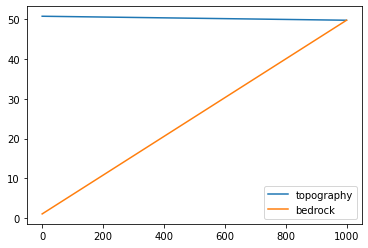

In [26]:
plt.plot(x, eta, label = 'topography')
plt.plot(x, etab, label = 'bedrock')
plt.legend()

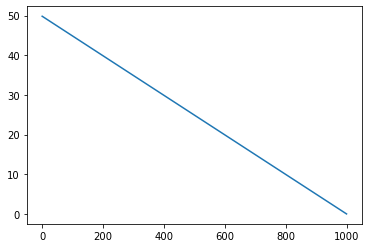

In [27]:
plt.plot(x, H)

In [28]:
ql

array([0.02491685, 0.07425498])

In [29]:
Eb_p

array([1.20210568e-51, 0.00000000e+00])

In [30]:
atr

array([0.00000000e+00, 5.74748357e-08])

In [31]:
np.diff(Qs)/dx

array([1.43687089e-06])